## Multiclass Classification using Pytorch

In [774]:
from sklearn.datasets import make_blobs
import pandas as pd
import matplotlib.pyplot as plt
import torch

### Prepare Play Dataset

In [775]:
N_SAMPLE = 5000
N_FEATURES = 2
RANDOM_STATE = 42
N_CLASSES = 4
NUM_TRAINING_EPOCHS = 100
X, y = make_blobs(n_samples=N_SAMPLE,
                  n_features=N_FEATURES,
                #   random_state=RANDOM_STATE,
                  centers=N_CLASSES,
                  cluster_std=2)

In [776]:
df = pd.DataFrame({
    "X1": X[:,0],
    "X2": X[:,1],
    "label": y
})
df.head(5)

,X1,X2,label
0,10.608603,-1.019937,1
1,11.622529,-4.235835,1
2,8.452689,-6.092566,1
3,11.518435,4.827226,0
4,-7.992295,10.594445,3


In [777]:
df.label.value_counts()

label
1    1250
0    1250
3    1250
2    1250
Name: count, dtype: int64

In [778]:
### Visualize Data
def plot_circles(x1, x2, labels):
    # plt.figure(figsize=[5,5])
    plt.scatter(
        x=x1, 
        y=x2,
        c=labels,
        s=20
    )
    plt.show()

def plot_circle_df(df):
    plot_circles(df.X1, df.X2, df.label)

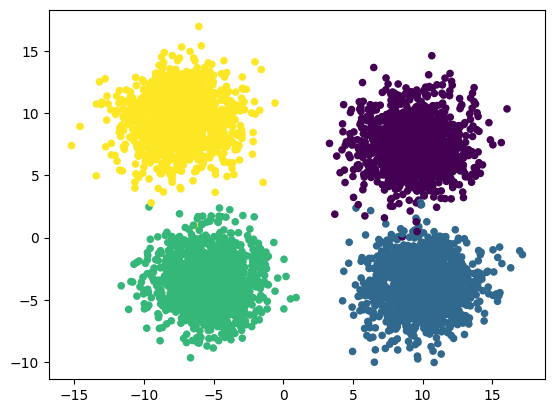

In [779]:
plot_circle_df(df)

### Pytorch Workflow

#### 1. Prepare Dataset (convert inputs to tensors)

In [780]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Shape of X[0]: {X[0].shape}")
print(f"Shape of y[0]: {y[0].shape}")

Shape of X: (5000, 2)
Shape of y: (5000,)
Shape of X[0]: (2,)
Shape of y[0]: ()


In [781]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.long)

In [782]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.int64)

In [783]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [784]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: torch.Size([4000, 2])
Shape of y_train: torch.Size([4000])
Shape of X_test: torch.Size([1000, 2])
Shape of y_test: torch.Size([1000])


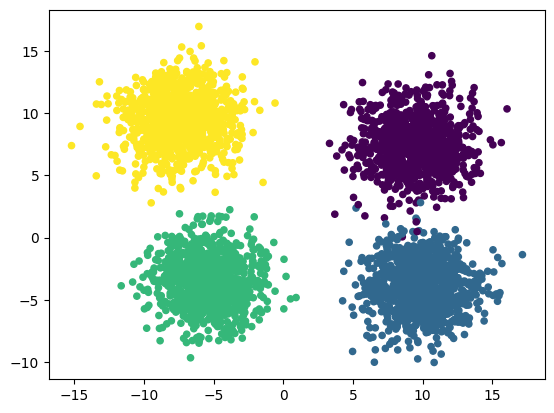

In [785]:
plot_circles(X_train[:, 0], X_train[:, 1], y_train)

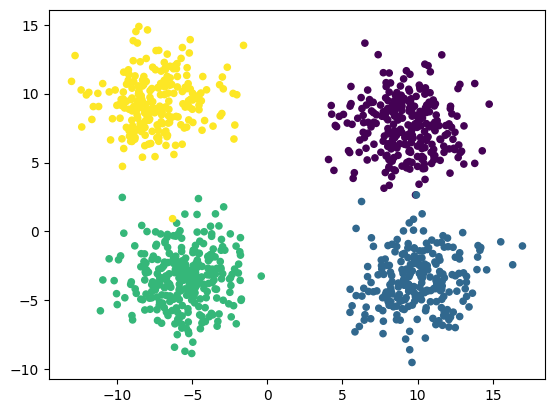

In [786]:
plot_circles(X_test[:, 0], X_test[:, 1], y_test)

#### 2. Build Model

1. Device agnostic code
2. Subclass nn.module
3. Define loss function and optimizer
4. Understand prediction shape
5. Training and Test Loop

In [787]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device", device)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

device cpu


In [788]:
class MultiClassClassifier(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        # self.layers = []
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(),
           
            nn.Linear(in_features=16, out_features=n_class),
            # nn.Softmax(dim=1), #the CrossEntropyLoss always applies softmax function internally. https://chatgpt.com/s/t_68c93b9c62e48191a2005ec26c93eafb
        )

    def forward(self, x):
        return self.layers(x)

In [789]:
classifier = MultiClassClassifier(N_CLASSES).to(device)
classifier

MultiClassClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [790]:
classifier.eval()
with torch.inference_mode():
    y_logits = classifier(X_test[:3])
y_logits.shape #N,4

torch.Size([3, 4])

So we have to convert logits to probabilities (softmax) and then to prediction (torch.argmax)

In [791]:
classifier.eval()
with torch.inference_mode():
    # Prediction logits
    y_logits = classifier(X_test[:3])

#Probabilities
y_prob = torch.softmax(y_logits, dim=1)
# Prediction Labels
y_prob, y_prob.argmax(dim=1)


(tensor([[0.1637, 0.2591, 0.1502, 0.4271],
         [0.1742, 0.1935, 0.1666, 0.4657],
         [0.2071, 0.2695, 0.1535, 0.3699]]),
 tensor([3, 3, 3]))

In [792]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
    params=classifier.parameters(),
    lr=0.01
)
accuracy_fn = lambda y_pred, y_real: 100*((y_pred == y_real).sum())/len(y_pred)

In [793]:
y_train.dtype

torch.int64

In [794]:
torch.random.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
num_epochs = NUM_TRAINING_EPOCHS
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    classifier.train()
    # Forward
    y_logits = classifier(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    # calculate loss
    loss = loss_fn(y_logits, y_train)
    train_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #accuracy metrics
    accuracy = accuracy_fn(y_pred, y_train)
    train_accuracies.append(accuracy.item())
    #Training loop
    classifier.eval()
    with torch.inference_mode():
        y_logits = classifier(X_test).squeeze()
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        loss = loss_fn(y_logits, y_test)
        test_losses.append(loss.item())
        accuracy = accuracy_fn(y_pred, y_test)
        test_accuracies.append(accuracy.item())

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_losses[-1]:.5f} | Train Accuracy: {train_accuracies[-1]:.2f}% | Test Loss: {test_losses[-1]:.5f} | Test Accuracy: {test_accuracies[-1]:.2f}%")

Epoch: 0 | Train Loss: 1.32443 | Train Accuracy: 27.17% | Test Loss: 1.17512 | Test Accuracy: 45.40%
Epoch: 10 | Train Loss: 0.26431 | Train Accuracy: 98.65% | Test Loss: 0.23421 | Test Accuracy: 98.80%
Epoch: 20 | Train Loss: 0.01927 | Train Accuracy: 99.78% | Test Loss: 0.01928 | Test Accuracy: 99.50%
Epoch: 30 | Train Loss: 0.00791 | Train Accuracy: 99.75% | Test Loss: 0.01543 | Test Accuracy: 99.50%
Epoch: 40 | Train Loss: 0.00742 | Train Accuracy: 99.80% | Test Loss: 0.01644 | Test Accuracy: 99.50%
Epoch: 50 | Train Loss: 0.00722 | Train Accuracy: 99.75% | Test Loss: 0.01749 | Test Accuracy: 99.50%
Epoch: 60 | Train Loss: 0.00693 | Train Accuracy: 99.80% | Test Loss: 0.01672 | Test Accuracy: 99.50%
Epoch: 70 | Train Loss: 0.00662 | Train Accuracy: 99.80% | Test Loss: 0.01661 | Test Accuracy: 99.50%
Epoch: 80 | Train Loss: 0.00635 | Train Accuracy: 99.80% | Test Loss: 0.01588 | Test Accuracy: 99.50%
Epoch: 90 | Train Loss: 0.00612 | Train Accuracy: 99.80% | Test Loss: 0.01553 | Tes

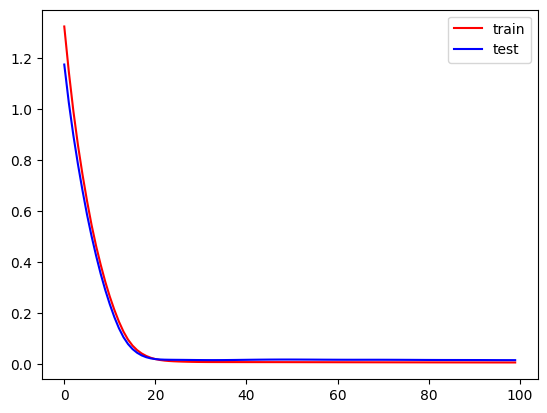

In [795]:
plt.plot(
    train_losses,
    color='r',
    label='train'
    
)
plt.plot(
    test_losses,
    color='b',
    label='test'
)
plt.legend()

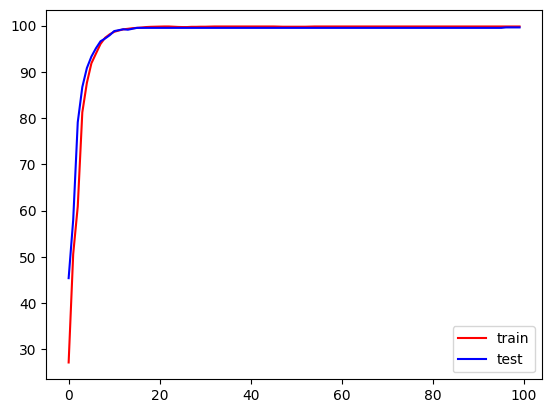

In [796]:
plt.plot(
    train_accuracies,
    color='r',
    label='train'
    
)
plt.plot(
    test_accuracies,
    color='b',
    label='test'
)
plt.legend()

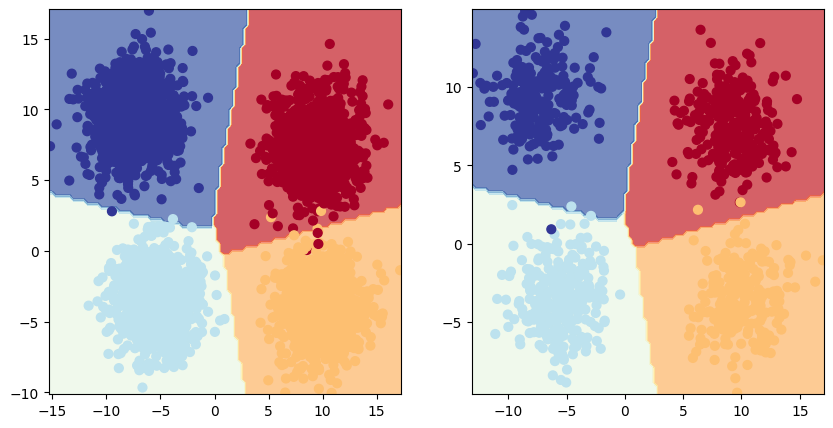

In [797]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plot_decision_boundary(classifier, X_train, y_train)
plt.subplot(1,2,2)
plot_decision_boundary(classifier, X_test, y_test)